# Importing required libraries

In [17]:
import  numpy as np
import os
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout,Flatten,Dense,GlobalAveragePooling2D


# Splitting data into training and testing

In [18]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = "dataset"  # Folder that contains class subfolders
output_base_dir = "train_data"  # Will contain 'train' and 'test'

train_dir = os.path.join(output_base_dir, "train")
test_dir = os.path.join(output_base_dir, "test")

# Create output folders
for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Loop through each class
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(len(images) * 0.8)
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Create class subfolders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy files
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copyfile(src, dst)

print("Dataset split complete!")


Dataset split complete!


# Counting total training and validation images

In [19]:

files_train=0 
files_validation=0 
cwd=os.getcwd()
folder="train_data/train"

for subfolder in os.listdir(folder):
    path,dirs,files=next(os.walk(os.path.join(folder,subfolder)))
    files_train+=len(files)
    
folder="train_data/test"
for subfolder in os.listdir(folder):
    path,dirs,files=next(os.walk(os.path.join(folder,subfolder)))
    files_validation+=len(files)
print(files_train,files_validation)

10 4


# Setting key parameters

In [20]:
img_width,img_height=48,48
train_data_dir="train_data/train/"
val_data_dir="train_data/test/"
nb_train_sample=files_train
nb_val_sample=files_validation
batch_size=32
epochs=100
num_classes=2


# Building model on top of a pretrained VGG
Load the VGG16 model without the top classification layers

In [21]:
model=applications.VGG16(weights='imagenet',include_top=False,input_shape=(img_width,img_height,3))

Show VGG16 model architecture


In [22]:
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

List the layers of the base VGG16 model

In [23]:
model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

freeze the first 10 layers

In [24]:

for layer in model.layers[:10]:
    layer.trainable=False

In [25]:
#Add custom classification
X=model.output
X=Flatten()(X)
predictions=Dense(num_classes,activation="softmax")(X)
#Create the final model
model_final=Model(inputs=model.input,outputs=predictions)
#Compile the model
model_final.compile(loss='categorical_crossentropy',optimizer="adam",metrics=["accuracy"])

Data Augmentation & Create generators for loading images from disk

In [26]:
train_datagen=ImageDataGenerator(rescale=1.0/255,horizontal_flip=True,fill_mode='nearest',zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,rotation_range=5)
test_datagen=ImageDataGenerator(rescale=1.0/255,horizontal_flip=True,fill_mode='nearest',zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,rotation_range=5)

train_generator=train_datagen.flow_from_directory(train_data_dir,target_size=(img_height,img_width),batch_size=batch_size,class_mode="categorical")
validation_generator=test_datagen.flow_from_directory(val_data_dir,target_size=(img_height,img_width),batch_size=batch_size,class_mode="categorical")


Found 10 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


Train the model using the generators

In [27]:
history=model_final.fit(
    train_generator,
    steps_per_epoch=nb_train_sample//batch_size,
    validation_steps=nb_val_sample//batch_size,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 0.8828 - val_accuracy: 0.5000 - val_loss: 1.7328
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5000 - loss: 1.5382 - val_accuracy: 0.5000 - val_loss: 1.1223
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5000 - loss: 1.1563 - val_accuracy: 0.5000 - val_loss: 0.7403
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5000 - loss: 0.7399 - val_accuracy: 0.5000 - val_loss: 0.7032
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5000 - loss: 0.7041 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5000 - loss: 0.6879 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_

Visualisation

In [28]:
history

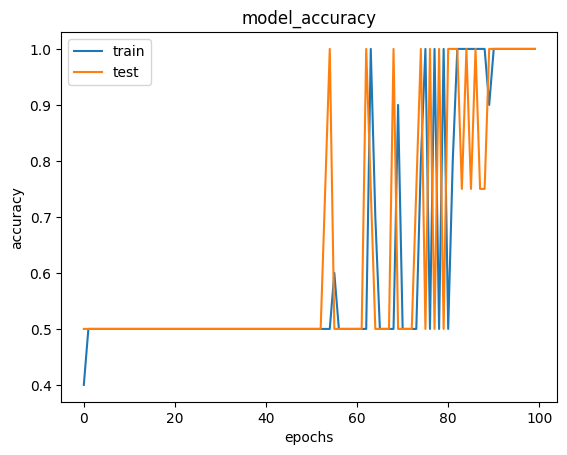

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(['train','test'],loc="upper left")
plt.show()


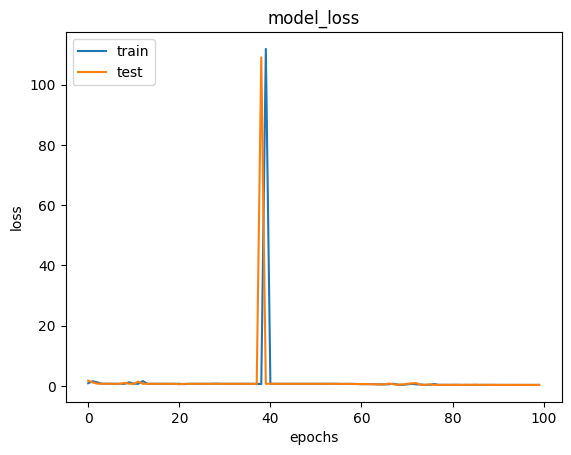

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(['train','test'],loc="upper left")
plt.show()


Test the model

In [32]:
class_dict={}
class_dict[0] = 'no_truck'
class_dict[1] = 'truck'
class_dict

{0: 'no_truck', 1: 'truck'}

In [33]:
import cv2
import numpy as np

def make_prediction(image):
    image=cv2.imread(image)
    image=cv2.resize(image,(48,48))
    img=image/255

    img=np.expand_dims(img,axis=0)

    class_predicted=model_final.predict(img)
    intID=np.argmax(class_predicted[0])
    label=class_dict[intID]
    return label

In [34]:
make_prediction("truck.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


'truck'

Save the model

In [35]:
model_final.save('model.h5')

In [ ]:
model_final.save('model.keras')